# DFA and Factor Investing

## HBS Case
### *Dimensional Fund Advisors, 2002 [HBS 9-203-026].

*Pages 1-5 of the case are required. Pages 6-11 get into interesting issues around trading (especially adverse selection) and tax considerations. These sections are useful for building market knowledge, but we will not cover them.**

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict

DATA_PATH = "data/dfa_analysis_data.xlsx"   
SHEET_NAME = "factors"                
DATE_COL = "Date"
FACTORS = ["Mkt-RF", "SMB", "HML"]    

SPLIT1_END = "1980-12-31"
SUB2_START = "1981-01-01"
SUB2_END = "2001-12-31"
SUB3_START = "2002-01-01"

# 2. The Factors

DFA believes certain stocks have higher expected excess returns. In addition to the overall market equity premium, DFA believes that there is a premium attached to a **size** and **value** factor. Note that these three factors are already listed as **excess** returns.

### Data
Use the data found in `data/dfa_analysis_data.xlsx`.

- Monthly **excess** return data for the overall equity market, $\tilde{r}^{\text{mkt}}$. 

- The sheet also contains data on two additional factors, `SMB` and `HML`, as well as the risk-free rate. 

- You do not need any of these columns for the homework. Just use the `MKT` column, which is **excess** market returns. (So no need to subtract the risk-free rate.)

#### Source:

Ken French library, accessible through the pandas-datareader API.

In [8]:
def load_and_prepare(path: str, sheet: str = SHEET_NAME) -> pd.DataFrame:
    df = pd.read_excel(path, sheet_name=sheet)
    df[DATE_COL] = pd.to_datetime(df[DATE_COL])
    df = df.set_index(DATE_COL).sort_index()

    missing = [c for c in FACTORS if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in sheet '{sheet}': {missing}")
    return df[FACTORS].copy()

def define_subsamples(df: pd.DataFrame) -> Dict[str, pd.DataFrame]:
    subsamples = {
        "Full": df,
        "Beginning - 1980": df.loc[:SPLIT1_END],
        "1981 - 2001": df.loc[SUB2_START:SUB2_END],
        "2002 - Present": df.loc[SUB3_START:]
    }
    return subsamples

df = load_and_prepare(DATA_PATH)
subsamples = define_subsamples(df)

### 1. The Factors

Calculate their univariate performance statistics: 

* mean
* volatility
* Sharpe
* VaR(.05)

Report these for the following three subsamples:

* Beginning - 1980
* 1981 - 2001
* 2002 - End

### 2. 

Based on the factor statistics above, answer the following.

- Does each factor have a premium (positive expected excess return) in each subsample?

- Does the premium to the size factor get smaller after 1980?

- Does the premium to the value factor get smaller during the 1990's?

- How have the factors performed since the time of the case, (2002-present)?

### 3.

The factors are constructed in such a way as to reduce correlation between them.

* Report the correlation matrix across the three factors. 

* Does the construction method succeed in keeping correlations small? 

* Does it achieve this in each subsample?

### 4. 

* Plot the cumulative returns of the three factors. 

* Create plots for the 1981-2001 subsample as well as the 2002-Present subsample.

### 5.

* Does it appear that all three factors were valuable in 1981-2001? 
* And post-2001? 

Would you advise DFA to continue emphasizing all three factors?

### 1.

In [9]:
def compute_univariate_stats(df: pd.DataFrame) -> pd.DataFrame:
    mean_m = df.mean() * 12
    vol_m = df.std() * np.sqrt(12)
    sharpe_m = mean_m / vol_m
    var05_m = df.quantile(0.05)   

    res = pd.DataFrame({
        "Mean (m)": mean_m,
        "Vol (m)": vol_m,
        "Sharpe (m)": sharpe_m,
        "VaR(5%) (m)": var05_m,
    })
    return res

def stats_for_all_subsamples(subsamples: Dict[str, pd.DataFrame]) -> Dict[str, pd.DataFrame]:
    stats = {}
    for name, data in subsamples.items():
        stats[name] = compute_univariate_stats(data)
    return stats

stats_dict = stats_for_all_subsamples(subsamples)

for name, table in stats_dict.items():
    print("\n" + "="*60)
    print(f"Stats for: {name}")
    print(table.round(6))


Stats for: Full
        Mean (m)   Vol (m)  Sharpe (m)  VaR(5%) (m)
Mkt-RF  0.082770  0.184134    0.449507     -0.07922
SMB     0.020105  0.109348    0.183858     -0.04180
HML     0.041614  0.123227    0.337699     -0.04241

Stats for: Beginning - 1980
        Mean (m)   Vol (m)  Sharpe (m)  VaR(5%) (m)
Mkt-RF  0.080958  0.204988    0.394938    -0.084090
SMB     0.033914  0.114277    0.296769    -0.041875
HML     0.050321  0.134228    0.374893    -0.044245

Stats for: 1981 - 2001
        Mean (m)   Vol (m)  Sharpe (m)  VaR(5%) (m)
Mkt-RF  0.077852  0.157183    0.495298    -0.064135
SMB    -0.002014  0.117260   -0.017178    -0.045880
HML     0.064557  0.109863    0.587613    -0.041640

Stats for: 2002 - Present
        Mean (m)   Vol (m)  Sharpe (m)  VaR(5%) (m)
Mkt-RF  0.091306  0.153529    0.594711    -0.077265
SMB     0.007931  0.088448    0.089669    -0.039195
HML     0.001204  0.106442    0.011313    -0.041485


### 2. 

In [10]:
def positive_premium_report(subsamples: Dict[str, pd.DataFrame]) -> pd.DataFrame:
    out = {}
    for name, data in subsamples.items():
        out[name] = (data.mean() > 0)
    dfpos = pd.DataFrame(out).T
    return dfpos

pos_prem = positive_premium_report(subsamples)
print("\n" + "="*60)
print("Positive premium (monthly mean > 0) by subsample:")
print(pos_prem)


Positive premium (monthly mean > 0) by subsample:
                  Mkt-RF    SMB   HML
Full                True   True  True
Beginning - 1980    True   True  True
1981 - 2001         True  False  True
2002 - Present      True   True  True


In [11]:
def positive_premium_report(subsamples: Dict[str, pd.DataFrame]) -> pd.DataFrame:
    out = {}
    for name, data in subsamples.items():
        out[name] = (data.mean() > 0)
    dfpos = pd.DataFrame(out).T
    return dfpos

pos_prem = positive_premium_report(subsamples)
print("\n" + "="*60)
print("Positive premium (monthly mean > 0) by subsample:")
print(pos_prem)


Positive premium (monthly mean > 0) by subsample:
                  Mkt-RF    SMB   HML
Full                True   True  True
Beginning - 1980    True   True  True
1981 - 2001         True  False  True
2002 - Present      True   True  True


- The premium to the SMB (size) factor gets smaller after 1980.
- The premium to the HML (value) factor gets smaller during the 1990's.
- The factors have performed since 2002 (2002–present):
  - Market: Strong
  - SMB (size): Remains marginally positive 
  - HML (value): Shows virtually no positive premium

### 3. 

In [12]:
def correlation_matrices(subsamples: Dict[str, pd.DataFrame]) -> Dict[str, pd.DataFrame]:
    corrs = {}
    for name, data in subsamples.items():
        corrs[name] = data.corr()
    return corrs

corrs = correlation_matrices(subsamples)
for name, c in corrs.items():
    print("\n" + "-"*40)
    print(f"Correlation matrix - {name}")
    print(c.round(4))


----------------------------------------
Correlation matrix - Full
        Mkt-RF     SMB     HML
Mkt-RF  1.0000  0.3204  0.2278
SMB     0.3204  1.0000  0.1258
HML     0.2278  0.1258  1.0000

----------------------------------------
Correlation matrix - Beginning - 1980
        Mkt-RF     SMB     HML
Mkt-RF  1.0000  0.3742  0.4423
SMB     0.3742  1.0000  0.3134
HML     0.4423  0.3134  1.0000

----------------------------------------
Correlation matrix - 1981 - 2001
        Mkt-RF     SMB     HML
Mkt-RF  1.0000  0.1587 -0.5299
SMB     0.1587  1.0000 -0.4455
HML    -0.5299 -0.4455  1.0000

----------------------------------------
Correlation matrix - 2002 - Present
        Mkt-RF     SMB     HML
Mkt-RF  1.0000  0.3160  0.1097
SMB     0.3160  1.0000  0.1162
HML     0.1097  0.1162  1.0000


The factor structure successfully maintains low correlations across the entire population (full sample), but the correlation structure varies significantly across different subsamples.

### 4.

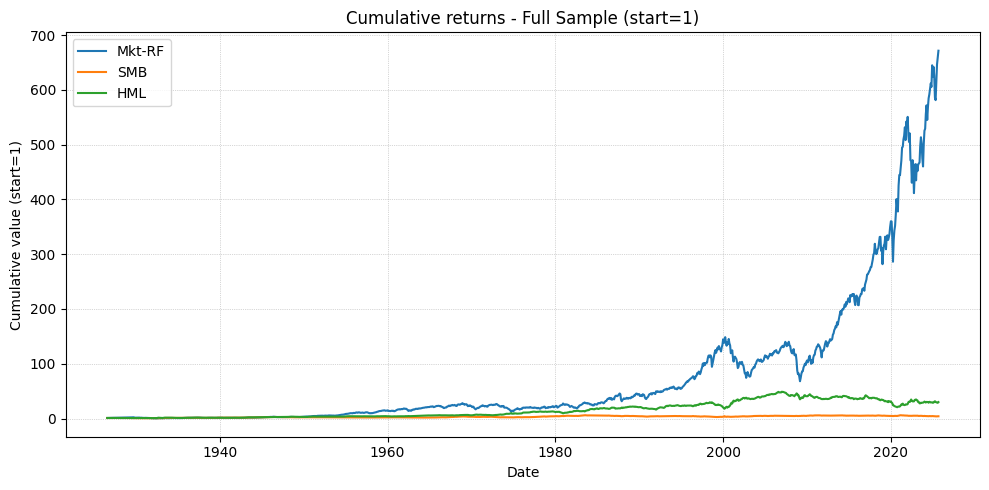

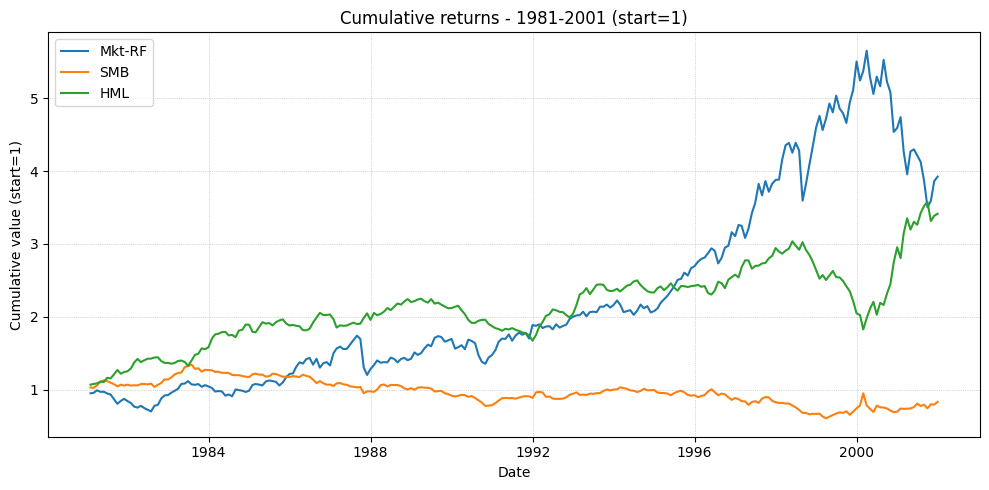

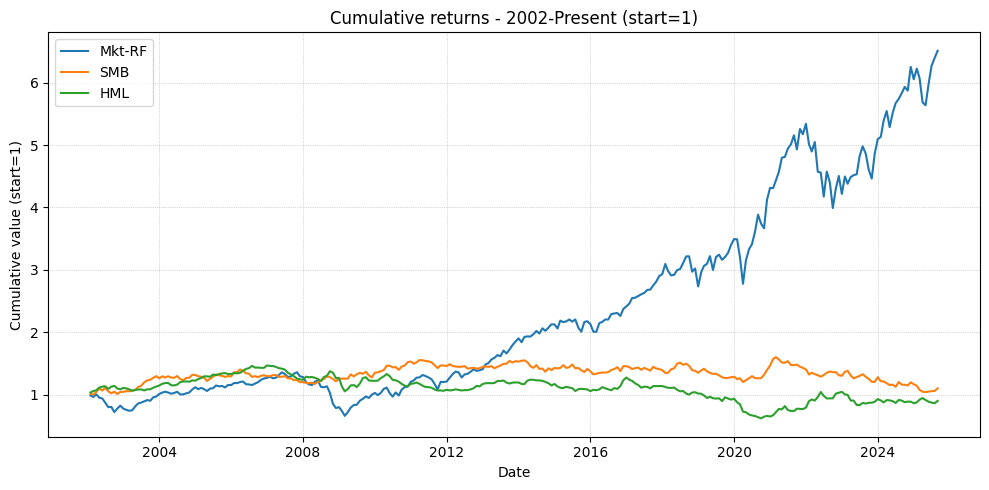

In [13]:
def plot_cumulative_returns(df: pd.DataFrame, factors: list = FACTORS,
                            title: str = "Cumulative returns", savepath: str = None):
    cum = (1 + df[factors]).cumprod()
    plt.figure(figsize=(10, 5))
    for f in factors:
        plt.plot(cum.index, cum[f], label=f)
    plt.legend()
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Cumulative value (start=1)")
    plt.grid(True, linestyle=':', linewidth=0.5)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=300)
    plt.show()
    plt.close()

plot_cumulative_returns(df, title="Cumulative returns - Full Sample (start=1)", savepath="cum_full.png")
plot_cumulative_returns(subsamples["1981 - 2001"], title="Cumulative returns - 1981-2001 (start=1)", savepath="cum_1981_2001.png")
plot_cumulative_returns(subsamples["2002 - Present"], title="Cumulative returns - 2002-Present (start=1)", savepath="cum_2002_present.png")

### 5. 

- 1981–2001: Value (HML) proved highly valuable during this cycle (with a significant positive premium and notable cumulative contribution), while Size (SMB) was unstable (even marginally negative). Therefore, emphasizing Value + Market during this period was more reasonable; equal weighting for Size may not have yielded additional gains.
- 2002–Present:
  - Market: Remains the dominant factor, delivering the best performance.
  - Size: Exhibits a marginal positive premium, but its magnitude is very small (annualized less than 1%), contributing little to long-term returns.
  - Value: Its premium has significantly diminished since the late 2000s (virtually zero from 2002 to present), weakening its status as a “long-term stable alpha” source (though note that value still exhibits significant reversion/reversal across different cycles).


Recommendations for DFA (Practical Level): Retain the three factors as a candidate pool (as they provide varying returns and hedging capabilities across different cycles), but employ dynamic weighting or risk budgeting methods to adjust the long-term position weights.

# 3. CAPM

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd

factor = pd.read_excel('data\dfa_analysis_data.xlsx', sheet_name='factors')
factor = factor.set_index('Date')
factor.index = pd.to_datetime(factor.index, format='%Y%m%d')
returns = pd.read_excel('data\dfa_analysis_data.xlsx', sheet_name='portfolios (total returns)')
returns = returns.set_index('Date')
returns.index = pd.to_datetime(returns.index, format='%Y%m%d')



DFA believes that premia in stocks and stock portfolios is related to the three factors. 

Let's test `25` equity portfolios that span a wide range of size and value measures.

#### Footnote
For more on the portfolio construction, see the description at Ken French's data library. 
https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/tw_5_ports.html

#### Portfolios
Monthly **total** return data on `25` equity portfolios sorted by their size-value characteristics. Denote these as $\vec{r}^{i}$, for $n=1, \ldots, 25$.
- Note that while the factors were given as excess returns, the portfolios are total returns.
- For this entire problem, focus on the 1981-Present subsample.

### 1. Summary Statistics. 

For each portfolio, 
- Use the Risk-Free rate column in the factors tab to convert these total returns to excess returns.
- Calculate the (annualized) univariate statistics from `1.1`.

In [15]:
excess_returns = returns.subtract(factor['RF'], axis=0)
df = excess_returns["1981":].copy()

freq = 12

def statistic(return_df, freq=12):
    mean = return_df.mean() * freq
    std = return_df.std() * np.sqrt(freq)
    Sharpe_ratio = mean / std
    VaR = return_df.quantile(0.05)
    return mean, std, Sharpe_ratio, VaR

mean_4, std_4, Sharpe_ratio_4, VaR_4 = statistic(df, freq)

Table_2 = pd.DataFrame({
    'Mean': mean_4,
    'Std': std_4,
    'Sharpe_ratio': Sharpe_ratio_4,
    'VaR': VaR_4,
})

print(Table_2.round(4))

              Mean     Std  Sharpe_ratio     VaR
SMALL LoBM  0.0117  0.2717        0.0431 -0.1249
ME1 BM2     0.0884  0.2354        0.3756 -0.0949
ME1 BM3     0.0902  0.2008        0.4493 -0.0848
ME1 BM4     0.1125  0.1940        0.5800 -0.0776
SMALL HiBM  0.1273  0.2084        0.6110 -0.0882
ME2 BM1     0.0609  0.2447        0.2490 -0.1032
ME2 BM2     0.0984  0.2054        0.4790 -0.0834
ME2 BM3     0.1052  0.1864        0.5640 -0.0803
ME2 BM4     0.1081  0.1819        0.5942 -0.0753
ME2 BM5     0.1132  0.2137        0.5298 -0.0933
ME3 BM1     0.0694  0.2237        0.3103 -0.0995
ME3 BM2     0.1040  0.1871        0.5555 -0.0786
ME3 BM3     0.0910  0.1729        0.5264 -0.0732
ME3 BM4     0.1053  0.1797        0.5863 -0.0722
ME3 BM5     0.1240  0.2024        0.6125 -0.0845
ME4 BM1     0.0919  0.2008        0.4575 -0.0835
ME4 BM2     0.0937  0.1761        0.5323 -0.0723
ME4 BM3     0.0920  0.1742        0.5282 -0.0762
ME4 BM4     0.1059  0.1741        0.6081 -0.0688
ME4 BM5     0.1056  

### 2. CAPM

The Capital Asset Pricing Model (CAPM) asserts that an asset (or portfolio's) expected excess return is completely a function of its beta to the equity market index (`SPY`, or in this case, `MKT`.) 

Specifically, it asserts that, for any excess return, $\tilde{r}^{i}$, its mean is proportional to the mean excess return of the market, $\tilde{r}^{\text{mkt}}$, where the proporitonality is the regression beta of $\tilde{r}^{i}$ on $\tilde{r}^{\text{mkt}}$.

$$
\mathbb{E}\left[\tilde{r}_{t}^{i}\right] = \beta^{i,\text{mkt}}\; \mathbb{E}\left[\tilde{r}_{t}^{\text{mkt}}\right]
$$

Let's examine whether that seems plausible.

For each of the $n=25$ test portfolios, run the CAPM time-series regression:

$$
\tilde{r}_{t}^{i} = \alpha^i + \beta^{i,\text{mkt}}\; \tilde{r}_{t}^{\text{mkt}} + \epsilon_{t}^{i}
$$

So you are running 25 separate regressions, each using the $T$-sized sample of time-series data.

* Report the betas and alphas for each test asset.

* Report the mean-absolute-error of the CAPM:
$$\text{MAE} = \frac{1}{n}\sum_{i=1}^n \left|\alpha_i\right|$$

If the CAPM were true, what would we expect of the MAE?

- Report the estimated $\beta^{i,\text{mkt}}$, Treynor Ratio, $\alpha^i$, and Information Ratio for each of the $n$ regressions.

- If the CAPM model were true, what would be true of the Treynor Ratios, alphas, and Information Ratios?

In [16]:
import statsmodels.api as sm

X = sm.add_constant(factor["Mkt-RF"]["1981":]) 


alphas, betas, r2, treynor, info_ratio = {}, {}, {}, {}, {}

for col in df.columns:
    y = df[col]
    model = sm.OLS(y, X).fit()
    alpha = model.params["const"]
    beta = model.params["Mkt-RF"]
    resid = model.resid

    alphas[col] = alpha
    betas[col] = beta
    r2[col] = model.rsquared

    # Treynor ratio = mean(excess return) / beta
    treynor[col] = y.mean() / beta if beta != 0 else np.nan

    # Information ratio = alpha / std(residual)
    info_ratio[col] = alpha / resid.std()

# === Table ===
capm_results = pd.DataFrame({
    "Alpha": alphas,
    "Beta (Mkt)": betas,
    "R^2": r2,
    "Treynor Ratio": treynor,
    "Information Ratio": info_ratio
}).T.round(4)

# Mean Absolute Error (|alpha| average)
MAE = np.mean(np.abs(capm_results.loc["Alpha"]))
print(f"\nMean Absolute Error (|alpha| average): {MAE:.4%}")


print("\nCAPM Regression Results:")
print(capm_results)


Mean Absolute Error (|alpha| average): 0.1728%

CAPM Regression Results:
                   SMALL LoBM  ME1 BM2  ME1 BM3  ME1 BM4  SMALL HiBM  ME2 BM1  \
Alpha                 -0.0086  -0.0009   0.0001   0.0025      0.0036  -0.0044   
Beta (Mkt)             1.3585   1.1658   1.0495   0.9773      0.9939   1.3341   
R^2                    0.6014   0.5900   0.6571   0.6105      0.5476   0.7154   
Treynor Ratio          0.0007   0.0063   0.0072   0.0096      0.0107   0.0038   
Information Ratio     -0.1746  -0.0204   0.0025   0.0703      0.0883  -0.1160   

                   ME2 BM2  ME2 BM3  ME2 BM4  ME2 BM5  ...  ME4 BM1  ME4 BM2  \
Alpha               0.0001   0.0014   0.0021   0.0016  ...  -0.0007   0.0003   
Beta (Mkt)          1.1390   1.0357   0.9765   1.1108  ...   1.1800   1.0577   
R^2                 0.7401   0.7426   0.6937   0.6505  ...   0.8308   0.8685   
Treynor Ratio       0.0072   0.0085   0.0092   0.0085  ...   0.0065   0.0074   
Information Ratio   0.0043   0.0523   0

In [17]:

market_mean = factor["Mkt-RF"]["1980":].mean()
market_std = factor["Mkt-RF"]["1980":].std()
market_sharpe = market_mean / market_std

print(f"Market Sharpe Ratio(Monthly): {market_sharpe:.4f}")

summary_compare = pd.DataFrame({
    "Mean Treynor Ratio": [capm_results.loc["Treynor Ratio"].mean()],
    "Market Sharpe Ratio": [market_sharpe],
    "Mean Alpha (%)": [capm_results.loc["Alpha"].mean() * 100],
    "Mean |Alpha| (%)": [np.abs(capm_results.loc["Alpha"]).mean() * 100],
    "Mean Information Ratio": [capm_results.loc["Information Ratio"].mean()]
}).T.round(4)

print("\n=== CAPM Summary Comparison ===")
print(summary_compare)

top_alpha = capm_results.loc["Alpha"].sort_values(ascending=False)
top_info = capm_results.loc["Information Ratio"].sort_values(ascending=False)

print("\nTop 5 Assets by Alpha:")
print(top_alpha.head(5))

print("\nTop 5 Assets by Information Ratio:")
print(top_info.head(5))

Market Sharpe Ratio(Monthly): 0.1618

=== CAPM Summary Comparison ===
                             0
Mean Treynor Ratio      0.0075
Market Sharpe Ratio     0.1618
Mean Alpha (%)          0.0272
Mean |Alpha| (%)        0.1728
Mean Information Ratio  0.0160

Top 5 Assets by Alpha:
SMALL HiBM    0.0036
ME3 BM5       0.0029
ME1 BM4       0.0025
ME2 BM4       0.0021
ME4 BM4       0.0019
Name: Alpha, dtype: float64

Top 5 Assets by Information Ratio:
SMALL HiBM    0.0883
ME3 BM5       0.0832
ME4 BM4       0.0768
ME2 BM4       0.0720
ME1 BM4       0.0703
Name: Information Ratio, dtype: float64


<span style="color: blue; font-size:0.85em">

<em>If CAPM were True:</em>

•  We expect portfolios to have similar Treynor ratios; Alphas ≈ 0; Information Ratios ≈ 0.

•  We expect MAE to be > 0 even if the CAPM is true, because idiosyncratic (residual) risk remains. As MAE reflects residual volatility, not the credibility of the model. Whether MAE is big is not relevent.

### 3. Cross-sectional Estimation

Let's test the CAPM directly. We already have what we need:

- The dependent variable, (y): mean excess returns from each of the $n=25$ portfolios.
- The regressor, (x): the market beta from each of the $n=25$ time-series regressions.

Then we can estimate the following equation:

$$
\underbrace{\mathbb{E}\left[\tilde{r}^{i}\right]}_{n\times 1\text{ data}} = \textcolor{ForestGreen}{\underbrace{\eta}_{\text{regression intercept}}} + \underbrace{{\beta}^{i,\text{mkt}};}_{n\times 1\text{ data}}~ \textcolor{ForestGreen}{\underbrace{\lambda_{\text{mkt}}}_{\text{regression estimate}}} + \textcolor{ForestGreen}{\underbrace{\upsilon}_{n\times 1\text{ residuals}}}
$$

Note that
- we use sample means as estimates of $\mathbb{E}\left[\tilde{r}^{i}\right]$. 
- this is a weird regression! The regressors are the betas from the time-series regressions we already ran!
- this is a single regression, where we are combining evidence across all $n=25$ series. Thus, it is a cross-sectional regression!
- the notation is trying to emphasize that the intercept is different than the time-series $\alpha$ and that the regressor coefficient is different than the time-series betas.

Report
- the R-squared of this regression.
- the intercept, $\eta$. 
- the regression coefficient, $\lambda_{\text{mkt}}$.

What would these three statistics be if the CAPM were completely accurate?

In [18]:
mean_excess_ret = df.mean()
betas = capm_results.loc["Beta (Mkt)"]

cross_section_df = pd.DataFrame({
    "Mean Excess Return": mean_excess_ret,
    "Beta (Mkt)": betas
}).dropna()

X = sm.add_constant(cross_section_df["Beta (Mkt)"])
y = cross_section_df["Mean Excess Return"]
model_cs = sm.OLS(y, X).fit()

eta = model_cs.params["const"]       
lambda_mkt = model_cs.params["Beta (Mkt)"] 
r2_cs = model_cs.rsquared

print("\n=== Cross-sectional CAPM Estimation ===")

# Summary Table
summary_cs = pd.DataFrame({
    "Statistic": ["Intercept (η)", "Market Price of Risk (λ_mkt)", "R-squared"],
    "Value": [eta, lambda_mkt, r2_cs]
})
print("\nSummary Table:")
print(summary_cs.round(4))


=== Cross-sectional CAPM Estimation ===

Summary Table:
                      Statistic   Value
0                 Intercept (η)  0.0172
1  Market Price of Risk (λ_mkt) -0.0088
2                     R-squared  0.3132


### 4. Conclusion

Broadly speaking, do these results support DFA's belieef in size and value portfolios containing premia unrelated to the market premium?

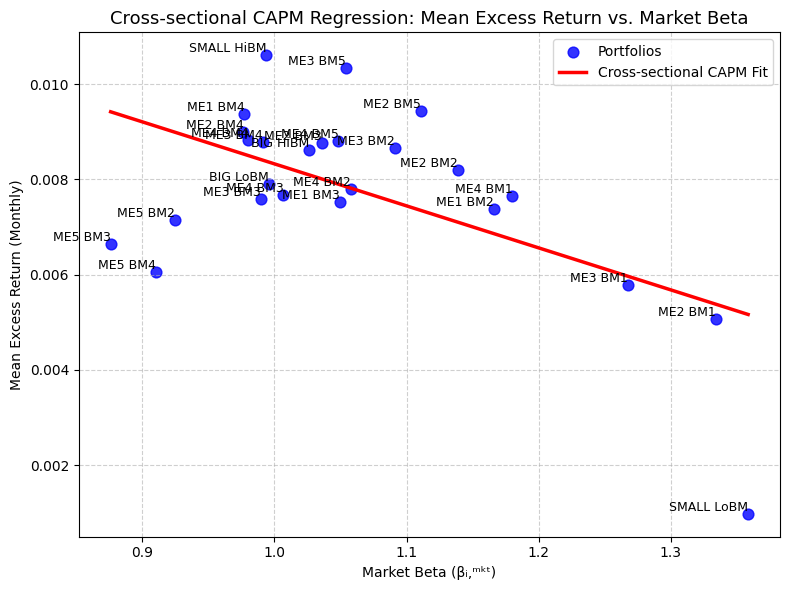

In [19]:

beta_range = np.linspace(cross_section_df["Beta (Mkt)"].min(),
                         cross_section_df["Beta (Mkt)"].max(), 100)
fitted_line = model_cs.params["const"] + model_cs.params["Beta (Mkt)"] * beta_range

plt.figure(figsize=(8,6))
plt.scatter(cross_section_df["Beta (Mkt)"], cross_section_df["Mean Excess Return"],
            color="blue", s=60, alpha=0.8, label="Portfolios")

plt.plot(beta_range, fitted_line, color="red", linewidth=2.5, label="Cross-sectional CAPM Fit")

for name, x, y in zip(cross_section_df.index,
                      cross_section_df["Beta (Mkt)"],
                      cross_section_df["Mean Excess Return"]):
    plt.text(x, y, name, fontsize=9, ha='right', va='bottom')

plt.title("Cross-sectional CAPM Regression: Mean Excess Return vs. Market Beta", fontsize=13)
plt.xlabel("Market Beta (βᵢ,ᵐᵏᵗ)")
plt.ylabel("Mean Excess Return (Monthly)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

<span style="color: blue; font-size:0.85em">

Yes. The cross-sectional CAPM on the 25 size-value portfolios (1981–present) shows a weak fit (R² ≈ 0.31), a large positive intercept (≈ 1.7% per month, ~20.6%/yr), and a negative slope (≈ −0.9% per month) despite the market’s positive mean excess return (~0.7% per month). 

This contradicts the CAPM Security Market Line (which requires a = 0 and a positive slope equal to the market mean), indicating that market beta alone cannot explain the cross-section of returns. 

In particular, portfolios with smaller market equity (ME) and higher book-to-market (BM) deliver higher returns than predicted by the CAPM. This evidence is consistent with distinct size and value effects, aligning with DFA’s view.

